In [105]:
import pyro
import torch
import numpy as np
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers import LogTrajectory
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:



class SimpleSlimeDynamics(pyro.nn.PyroModule):

    # About the model
    # B:     the number of spatial bins
    # D:     the density of slime mold agents
    # P:     the density of pheromones
    # dD/dt: slime mold follows pheromones
    # dP/dt: pheromones are deposited by slime mold, then diffuse
    # alpha: pheromone deposition rate
    # beta:  pheromone diffusion rate
    # r:     slime mold following rate

    def __init__(self, B, alpha, beta, r):
        super().__init__()
        self.B = B
        self.alpha = alpha
        self.beta = beta
        self.r = r

    @pyro.nn.pyro_method
    def diff(self, dstate: State[torch.Tensor], state: State[torch.Tensor]) -> None:
        deposition_term = self.alpha * state["D"]
        diffusion_term = self.beta * (torch.roll(state["P"], 1) + torch.roll(state["P"], -1) - 2 * state["P"])

        pheromone_right = torch.relu(torch.roll(state["P"], 1) - state["P"])
        pheromone_left = torch.relu(torch.roll(state["P"], -1) - state["P"])
        slime_flux_right = self.r * pheromone_right * state["D"]
        slime_flux_left = self.r * pheromone_left * state["D"]

        dstate["D"] = torch.roll(slime_flux_right, -1) - slime_flux_right
        dstate["D"] += torch.roll(slime_flux_left, 1) - slime_flux_left
        dstate["P"] = deposition_term + diffusion_term


    def forward(self, state: State[torch.Tensor]):
        dstate = State()
        self.diff(dstate, state)
        return dstate

# todo add params
B = torch.tensor(200)
alpha = torch.tensor(0.1)
beta = torch.tensor(0.1)
r = torch.tensor(1)
model = SimpleSlimeDynamics(B, alpha, beta, r)

# todo add initial state
# initial D is a torch array of size B
with pyro.plate("bins", B):
    D_initial = pyro.sample("D_initial", pyro.distributions.Uniform(0, 1))
    P_initial = pyro.sample("P_initial", pyro.distributions.Uniform(0, .1))
initial_state = State(D=D_initial, P=P_initial)
start_time = torch.tensor(0.0)
end_time = torch.tensor(100.0)
step_size = torch.tensor(0.1)
trajectory_times = torch.arange(start_time+step_size, end_time, step_size)


with LogTrajectory(trajectory_times) as lt:
    final_state = simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())

trajectory = lt.trajectory

In [107]:
trajectory['D'].sum(dim=0)

tensor([95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295, 95.8295,
        95.8295, 95.8295, 95.8295, 95.82

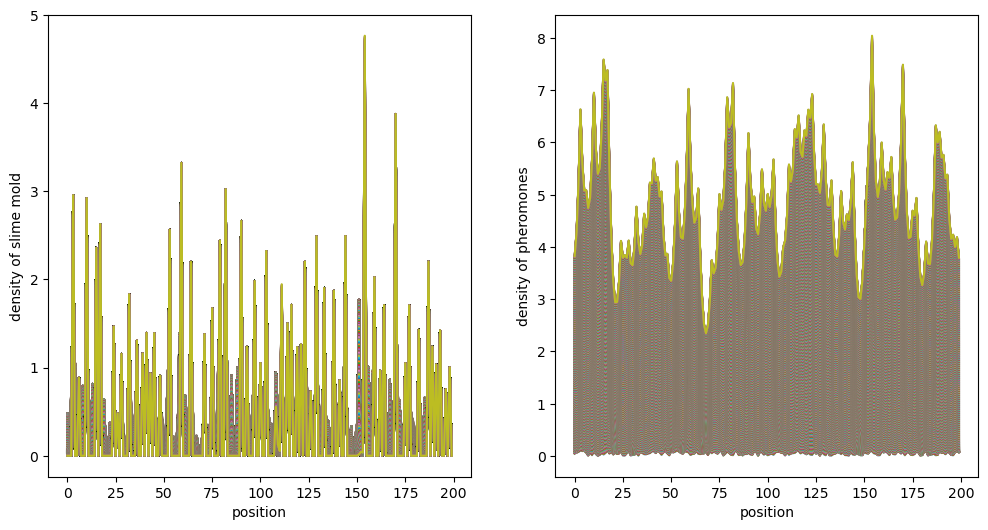

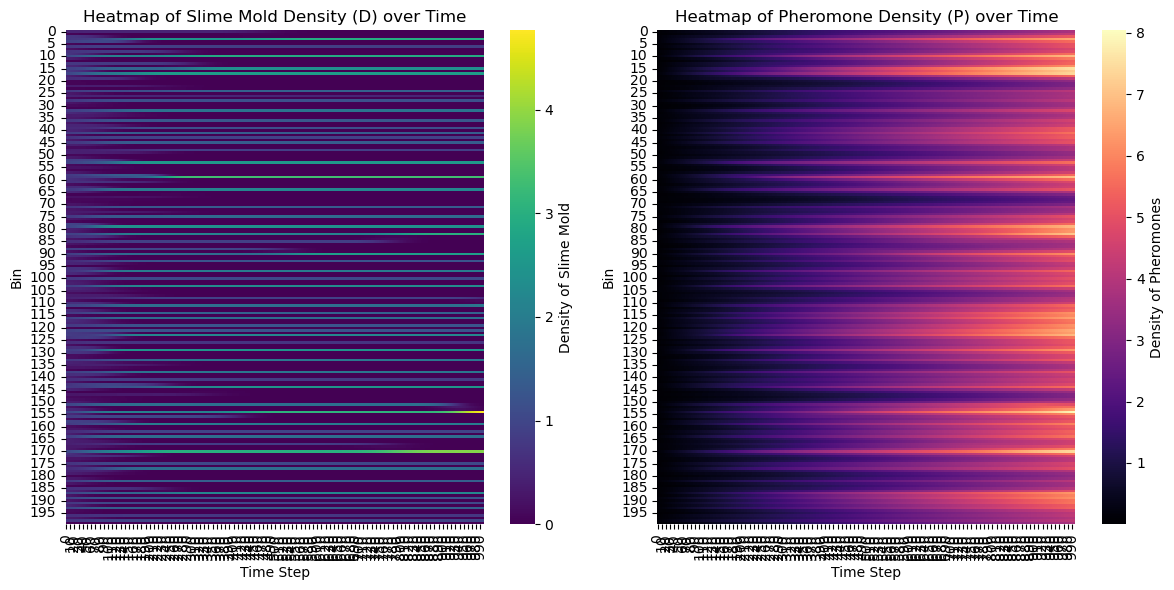

In [108]:

# Extracting D and P from the trajectory
D_trajectory = trajectory["D"]
P_trajectory = trajectory["P"]

# Time points
time_points = trajectory_times.numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plotting D, as a function of space
plt.subplot(1, 2, 1)
for t in range(len(time_points)):
    plt.plot(D_trajectory[:,t], label="t={}".format(time_points[t]))
plt.xlabel('position')
plt.ylabel('density of slime mold')

# Plotting P, as a function of space
plt.subplot(1, 2, 2)
for t in range(len(time_points)):
    plt.plot(P_trajectory[:,t], label="t={}".format(time_points[t]))
plt.xlabel('position')
plt.ylabel('density of pheromones')


# Plotting
plt.figure(figsize=(12, 6))

# Heatmap for D
plt.subplot(1, 2, 1)
sns.heatmap(D_trajectory, cmap="viridis", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Slime Mold'})
plt.title('Heatmap of Slime Mold Density (D) over Time')
plt.xlabel('Time Step')
plt.ylabel('Bin')

# Heatmap for P
plt.subplot(1, 2, 2)
sns.heatmap(P_trajectory, cmap="magma", xticklabels=10, yticklabels=5, cbar_kws={'label': 'Density of Pheromones'})
plt.title('Heatmap of Pheromone Density (P) over Time')
plt.xlabel('Time Step')
plt.ylabel('Bin')

plt.tight_layout()
plt.show()

